In [ ]:
import io
import os
import requests
import torchvision
from PIL import Image
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.nn import functional as F
import torch.optim as optim
import numpy as np
import cv2
import pdb
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

cuda


In [ ]:
root_dir = './data/MNIST/'
torchvision.datasets.MNIST(root = root_dir, download = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/MNIST/
    Split: Train

In [ ]:
train_set = torchvision.datasets.MNIST(root = root_dir, train = True, download = True)

In [ ]:
MNIST_dataset = torch.utils.data.DataLoader(train_set, batch_size = 1, shuffle = True, num_workers = 1)

In [ ]:
images = train_set.data.numpy().astype(np.float32) / 255
labels = train_set.targets.numpy()

In [ ]:
# plot multiple images
def plots(ims, interp=False, titles=None):
    ims=np.array(ims)
    mn,mx=ims.min(),ims.max()
    f = plt.figure(figsize=(12,24))
    for i in range(len(ims)):
        sp=f.add_subplot(1, len(ims), i+1)
        if not titles is None: sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=None if interp else 'none', vmin=mn,vmax=mx)

# plot a single image
def plot(im, interp=False):
    f = plt.figure(figsize=(3,6), frameon=True)
    plt.imshow(im, interpolation=None if interp else 'none')

plt.gray()
plt.close()

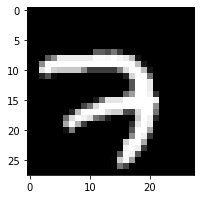

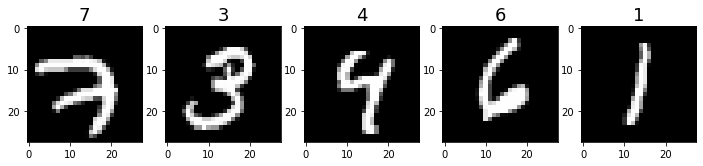

In [ ]:
plot(images[5000])
plots(images[5000:5005], titles=labels[5000:5005])

In [ ]:
# Simple CNN Network, deterministic
class CNN_MNIST(nn.Module):
    def __init__(self, dim1 = 20, dim2 = 20):
        super(CNN_MNIST, self).__init__()
        self.cn1 = nn.Conv2d(in_channels= 1, out_channels = 32 , kernel_size=(3,3))
        self.cn2 = nn.Conv2d(in_channels= 32, out_channels = 8 , kernel_size=(3,3))
        self.mp1 = nn.MaxPool2d((3,3))

        self.fc1 = nn.Linear(512, dim1)
        self.fc2 = nn.Linear(dim1, dim2)
        self.fc3 = nn.Linear(dim2, 10)
        self.ls = nn.LogSoftmax()
        
    def forward(self, x):
        y = torch.relu(self.cn1(x))
        y = torch.relu(self.cn2(y))
        y = self.mp1(y)
        y = torch.flatten(y , start_dim = 1)
        y = torch.tanh(self.fc1(y))
        y = torch.tanh(self.fc2(y))
        y = self.fc3(y)
        y = self.ls(y)
        return y

model = CNN_MNIST().to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
batch_size = 128

data_dir = 'data'
# MNIST dataset
dataset = torchvision.datasets.MNIST(root=data_dir,
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

In [ ]:
mask = [True for i in range(len(dataset.targets))]

In [ ]:
dataset = torch.utils.data.TensorDataset(dataset.data[mask].float(), dataset.targets[mask].byte())
train_loader = torch.utils.data.DataLoader(dataset, batch_size=128)

In [ ]:
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

In [ ]:
# num_epochs = 20
num_epochs = 2
# Start training
loss = torch.nn.NLLLoss()
for epoch in range(num_epochs):
    correct = 0
    total = 0
    for i, (x, y) in enumerate(train_loader):
        # Forward pass
        x = x.unsqueeze(1).to(device)
        y = y.to(device)

        y_pred = model(x)

        output = loss(y_pred, y)
        correct += torch.sum(torch.argmax(y_pred, dim = 1) == y)
        total += x.shape[0]
        optimizer.zero_grad()
        output.backward()
        optimizer.step()
        
        if i == 0:
            print ("Epoch[{}/{}], loss: {:.4f}, accuracy: {:.4f}" 
                   .format(epoch+1, num_epochs, output.item(), correct / total))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch[1/2], loss: 2.3734, accuracy: 0.1016
Epoch[2/2], loss: 0.3064, accuracy: 0.9375


In [ ]:
# your implementation of the attack
def fgsm_attack(image, epsilon, data_grad, device):
    # Collect the element-wise sign of the data gradient
    gradient_sign = (2 * (data_grad >= 0) - 1).type(torch.float).to(device) # renvoie 1 si le gradient est positif, -1 s'il est négatif
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * gradient_sign
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clip(perturbed_image, 0, 1).to(device)
    # Return the perturbed image
    return perturbed_image

In [ ]:
tensor = torch.zeros(10, 10)
tensor[0, 2] = 1
torch.argsort(-tensor.reshape(1, -1)).squeeze(0)[:5]

tensor([ 2, 62, 74, 73, 72])

In [ ]:
# your implementation of the attack
def fgsm_attack_pixelwise(image, epsilon, data_grad, device):
    # Collect the element-wise sign of the data gradient
    gradient_sign = (2 * (data_grad >= 0) - 1).type(torch.float).to(device) # renvoie 1 si le gradient est positif, -1 s'il est négatif
    pixel_to_be_changed = torch.argmax(torch.abs(data_grad)).item()
    tensor = torch.zeros(image.shape).to(device)
    x = pixel_to_be_changed // 28
    y = pixel_to_be_changed % 28
    print(x, y)
    tensor[x, y] = 1
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * gradient_sign * tensor
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clip(perturbed_image, 0, 1).to(device)
    # Return the perturbed image
    return perturbed_image

In [ ]:
# your implementation of the attack
def fgsm_attack_multipixelwise(image, epsilon, data_grad, device, number_pixels):
    # Collect the element-wise sign of the data gradient
    gradient_sign = (2 * (data_grad >= 0) - 1).type(torch.float).to(device) # renvoie 1 si le gradient est positif, -1 s'il est négatif
    # pixel_to_be_changed = torch.argmax(torch.abs(data_grad)).item()
    # pixel_to_be_changed = torch.argmax(data_grad).item()
    pixels_to_be_changed = torch.argsort(-torch.abs(data_grad).reshape(1, -1)).squeeze(0)[:number_pixels]
    tensor = torch.zeros(image.shape).to(device)
    x = pixels_to_be_changed // 28
    y = pixels_to_be_changed % 28
    print(x, y)
    for i in range (number_pixels):
      tensor[x[i].item(), y[i].item()] = 1
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * gradient_sign * tensor
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clip(perturbed_image, 0, 1).to(device)
    # Return the perturbed image
    return perturbed_image

In [ ]:
def adversarial(net, x_img, idx, device, number_pixels = 40):
  criterion = nn.CrossEntropyLoss()
  x_img.requires_grad = True
  target = torch.tensor([idx]).to(device)
  logit = net(x_img.unsqueeze(0).unsqueeze(0))
  print("Original classes :")
  print(np.argmax(logit.cpu().detach().numpy()))
  loss = criterion(logit, target)
  loss.backward()
  data_grad = x_img.grad # compute the loss to backpropagate
  print("Shape of data_grad : ", data_grad.shape)
  # your attack here
  epsilon = 0.4
  # x_att = fgsm_attack_multipixelwise(x_img, epsilon, data_grad, device, number_pixels)
  x_att = fgsm_attack_multipixelwise(x_img, epsilon, data_grad, device, number_pixels)
  # can you see the difference?
  print("Modified image :")
  plot(x_att.cpu().detach().numpy())
  return x_att

In [ ]:
example = 35
target = 3

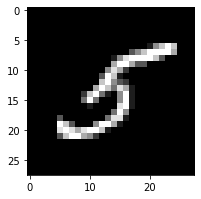

In [ ]:
plot(images[example])

In [ ]:
proba_min = 1
k_min = -1
for k in range (100):
  proba, prediction, label = torch.max(model(torch.from_numpy(images[k]).to(device).unsqueeze(0).unsqueeze(0))).item(), torch.argmax(model(torch.from_numpy(images[k]).to(device).unsqueeze(0).unsqueeze(0))).item(), labels[k]
  if (prediction == label and proba < proba_min):
    k_min = k
    proba_min = proba
print(k_min, proba_min)

35 -1.8501211404800415


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
print(torch.argmax(model(torch.from_numpy(images[example]).to(device).unsqueeze(0).unsqueeze(0))))

tensor(5, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Original classes :
5
Shape of data_grad :  torch.Size([28, 28])
tensor([17, 23, 17, 23, 17, 15, 23, 16, 17, 16, 21, 24, 18, 21, 10, 17, 16,  4,
        24, 22, 18, 23, 15,  4,  5, 22, 10, 18, 18,  4, 10, 23, 21, 22, 10, 23,
         5, 10, 19,  3], device='cuda:0') tensor([ 9,  6,  8,  4,  7, 10,  5,  9, 10,  7,  7,  6, 10,  8, 19, 11,  8, 22,
         7,  4,  9,  7, 11, 21, 24,  3, 20, 11,  7, 23, 13,  8,  6,  2, 15,  9,
        23, 18,  6, 21], device='cuda:0')
Modified image :


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  if __name__ == '__main__':


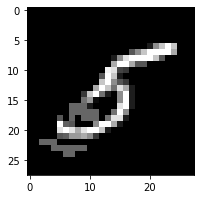

In [ ]:
image_attacked = adversarial(model, torch.from_numpy(images[example]).to(device), target, device)

In [ ]:
print(torch.argmax(model(image_attacked.unsqueeze(0).unsqueeze(0))))

tensor(8, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Original classes :
4
Shape of data_grad :  torch.Size([28, 28])
Modified image :
Original classes :
4
Shape of data_grad :  torch.Size([28, 28])
Modified image :
Original classes :
4
Shape of data_grad :  torch.Size([28, 28])
Modified image :
Original classes :
4
Shape of data_grad :  torch.Size([28, 28])
Modified image :
Original classes :
4
Shape of data_grad :  torch.Size([28, 28])
Modified image :
Original classes :
7
Shape of data_grad :  torch.Size([28, 28])
Modified image :
Original classes :
7
Shape of data_grad :  torch.Size([28, 28])
Modified image :
Original classes :
7
Shape of data_grad :  torch.Size([28, 28])
Modified image :
Original classes :
7
Shape of data_grad :  torch.Size([28, 28])
Modified image :
Original classes :
7
Shape of data_grad :  torch.Size([28, 28])
Modified image :
Original classes :
7
Shape of data_grad :  torch.Size([28, 28])
Modified image :
Original classes :
7
Shape of data_grad :  torch.Size([28, 28])
Modified image :
Original classes :
7
Shape o

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


Original classes :
7
Shape of data_grad :  torch.Size([28, 28])
Modified image :
Original classes :
7
Shape of data_grad :  torch.Size([28, 28])
Modified image :
Original classes :
7
Shape of data_grad :  torch.Size([28, 28])
Modified image :
Original classes :
7
Shape of data_grad :  torch.Size([28, 28])
Modified image :
Original classes :
7
Shape of data_grad :  torch.Size([28, 28])
Modified image :
Original classes :
7
Shape of data_grad :  torch.Size([28, 28])
Modified image :
Original classes :
7
Shape of data_grad :  torch.Size([28, 28])
Modified image :
Original classes :
7
Shape of data_grad :  torch.Size([28, 28])
Modified image :
Original classes :
7
Shape of data_grad :  torch.Size([28, 28])
Modified image :
Original classes :
7
Shape of data_grad :  torch.Size([28, 28])
Modified image :
Original classes :
7
Shape of data_grad :  torch.Size([28, 28])
Modified image :
Original classes :
7
Shape of data_grad :  torch.Size([28, 28])
Modified image :
Original classes :
7
Shape o

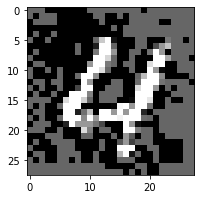

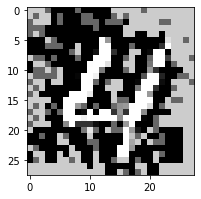

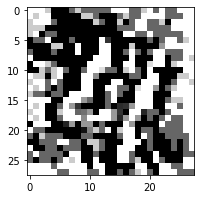

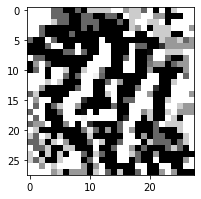

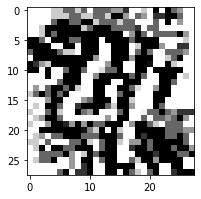

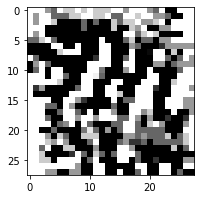

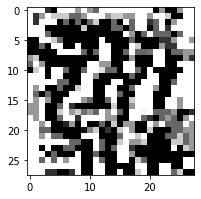

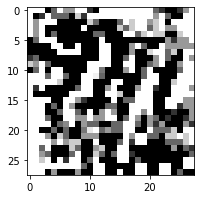

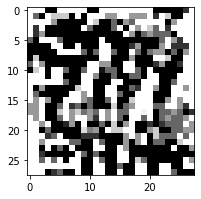

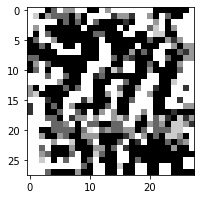

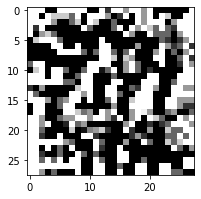

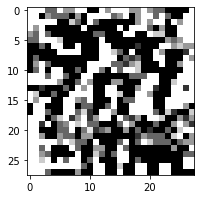

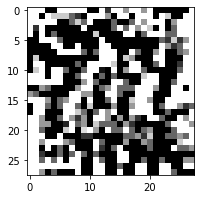

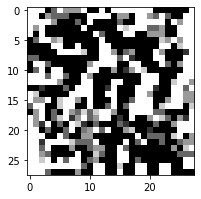

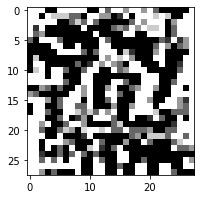

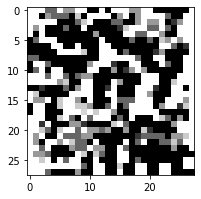

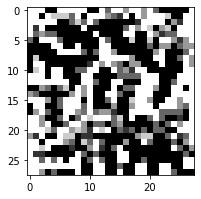

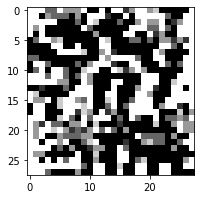

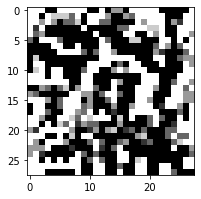

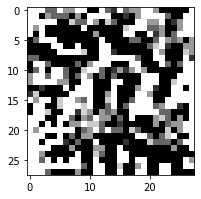

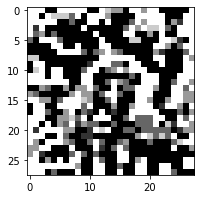

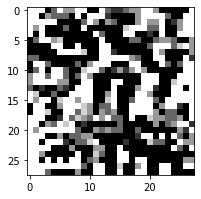

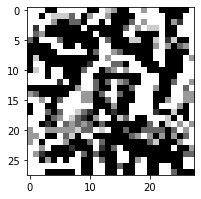

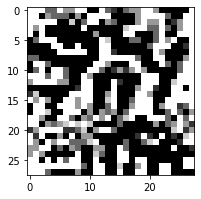

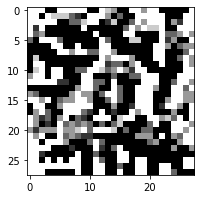

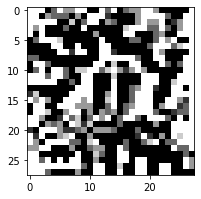

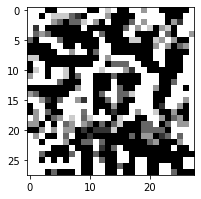

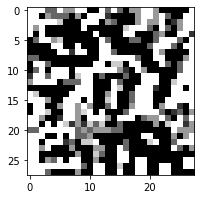

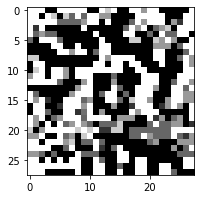

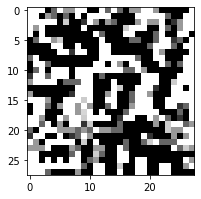

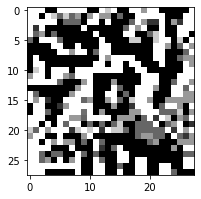

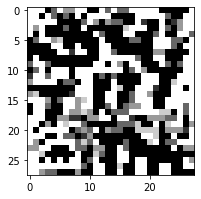

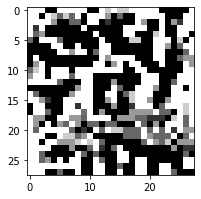

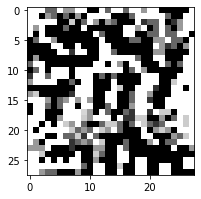

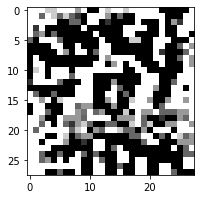

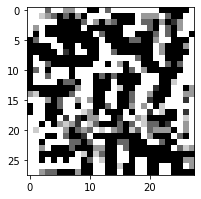

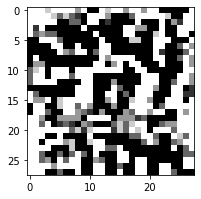

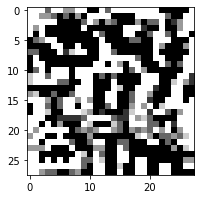

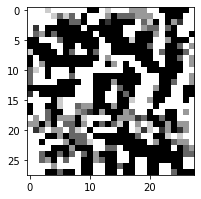

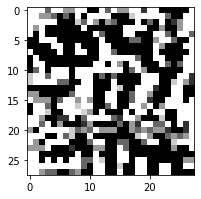

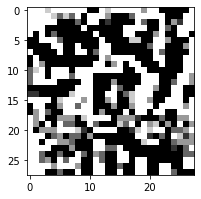

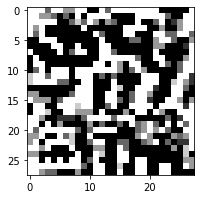

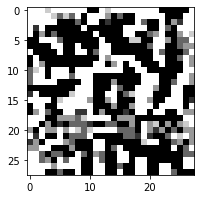

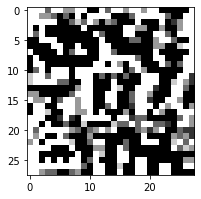

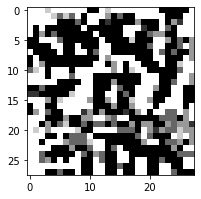

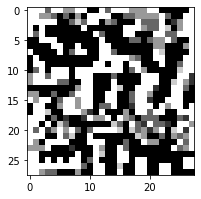

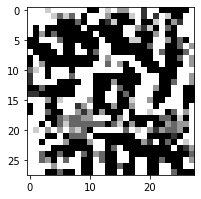

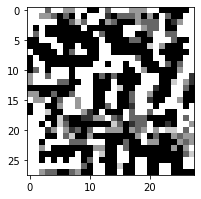

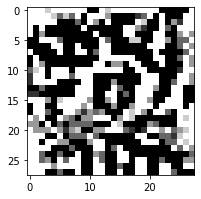

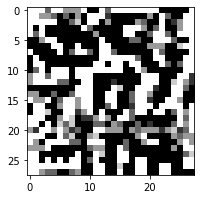

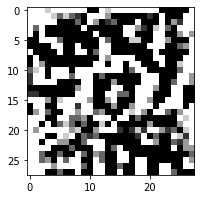

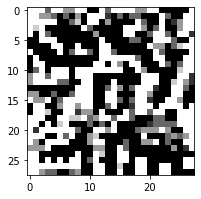

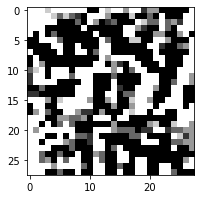

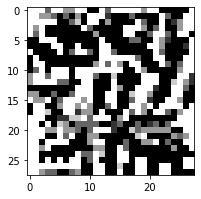

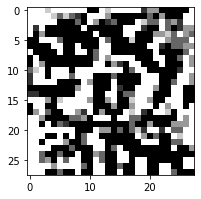

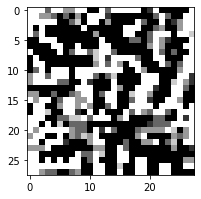

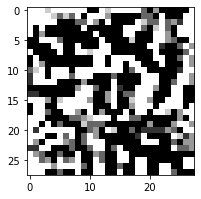

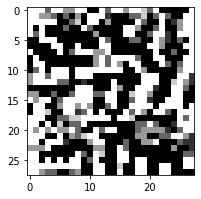

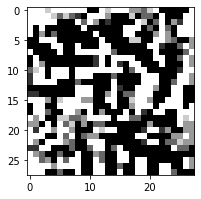

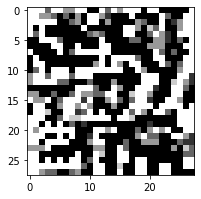

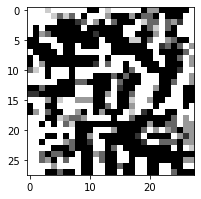

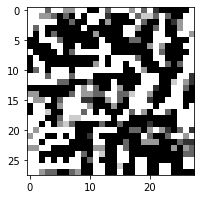

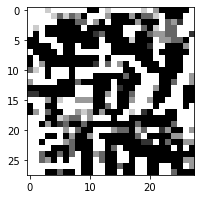

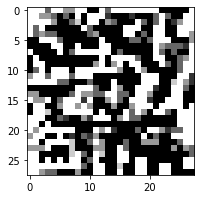

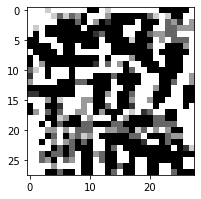

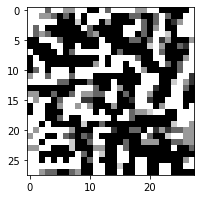

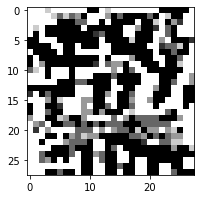

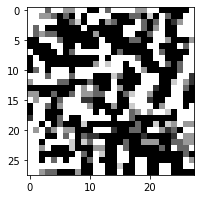

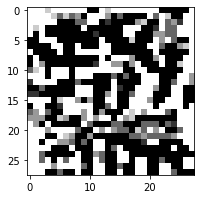

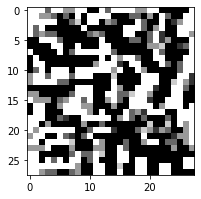

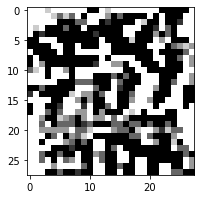

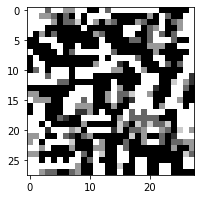

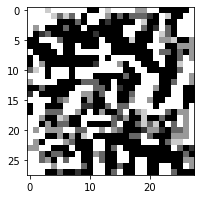

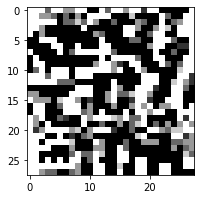

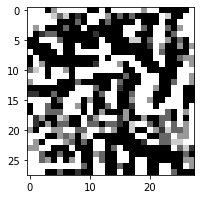

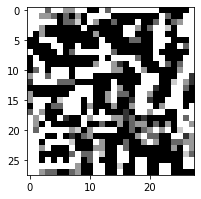

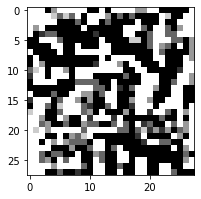

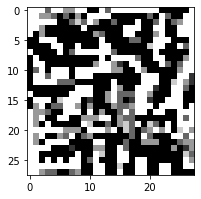

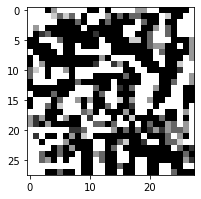

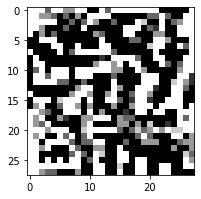

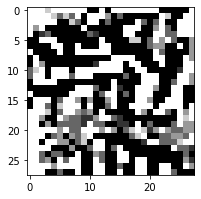

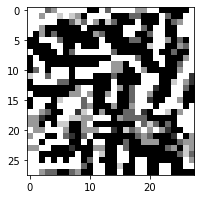

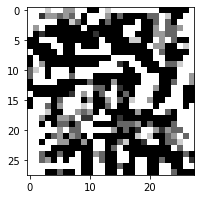

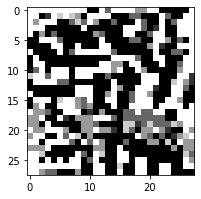

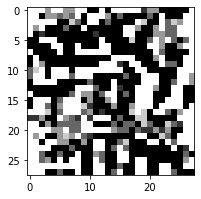

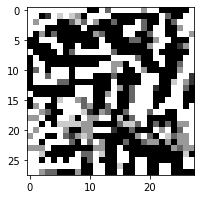

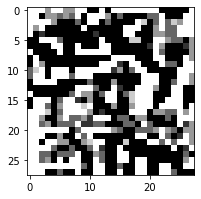

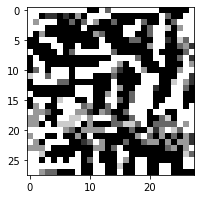

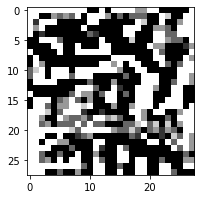

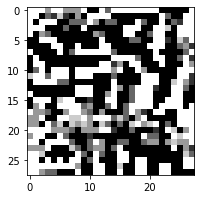

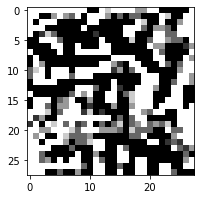

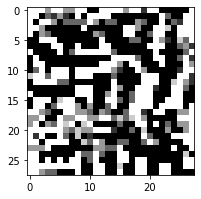

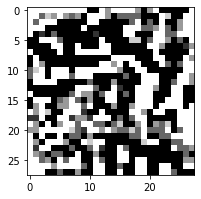

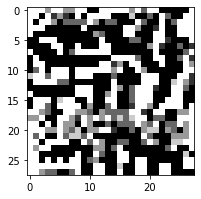

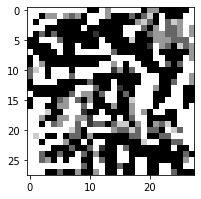

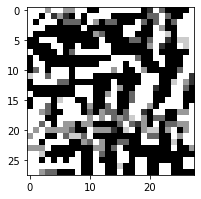

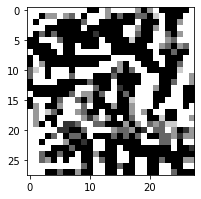

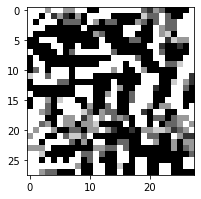

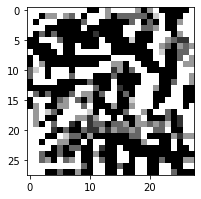

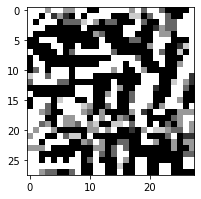

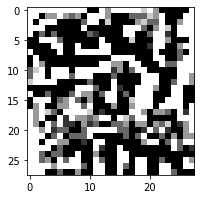

In [ ]:
image_attacked = adversarial(model, torch.from_numpy(images[example]).to(device), target, device)
predicted = torch.argmax(model(image_attacked.unsqueeze(0).unsqueeze(0))).item()
for _ in range (100):
  image_attacked = adversarial(model, image_attacked.detach(), target, device)
  predicted = torch.argmax(model(image_attacked.unsqueeze(0).unsqueeze(0))).item()
print(predicted)